This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

We are interested in analyzing the differences in L1000 in two cell lines, A579 and MCF7, looking at trichostatin-a vs DMSO.

We will compare this with the single cell measurements from sci-Plex.

Out perturbed bulk is a mixture of the two cell lines, with and without treatment. We will focus on one dose level: 10 µM

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from matplotlib.pyplot import rc_context

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.23.5 scipy==1.8.1 pandas==1.5.3 scikit-learn==1.3.1 statsmodels==0.14.0 python-igraph==0.10.8 pynndescent==0.5.10


## Open files

In [2]:
data_path = f"{os.getcwd()}/../../data/bulk_data/l1000/"

# file downloaded from GSE92742 in gtcx format, then filtered and written to tsv


in_file = f"{data_path}/GSE92742_Broad_LINCS_Level2_GEX_epsilon_filt_expr.tsv"
meta_file = f"{data_path}/GSE92742_Broad_LINCS_Level2_GEX_epsilon_filt_sig.tsv"
results_file = f"{data_path}/l1000_bulk_processed.h5ad"

# read in the expressiong table
expr_df = pd.read_csv(in_file, sep="\t")

# get the genes
expr_df_var = expr_df[["pr_gene_id", "pr_gene_symbol"]]
expr_df.drop(columns=["pr_gene_id", "pr_gene_symbol"], inplace=True)
expr_df_var.index = expr_df_var.pr_gene_symbol

# format expression data
expr_df = expr_df.transpose()
expr_df.columns = expr_df_var.pr_gene_symbol

# get sample metadata
obs_df = pd.read_csv(meta_file, sep="\t")
obs_df["distil_id"] = obs_df['distil_id'].str.replace(':','.')
obs_df = obs_df.set_index(obs_df["distil_id"])
obs_df = obs_df.loc[expr_df.index.to_list()]

# format the metadata so that it doesn't have repeats
idx_DMSO_dose = np.where((obs_df["pert_iname"] == "DMSO") & (obs_df["pert_dose"] < 0))[0]
idx_nonDMSO = np.where(obs_df["pert_iname"] != "DMSO")[0]
idx_both = np.union1d(idx_DMSO_dose, idx_nonDMSO)
obs_df = obs_df.iloc[idx_both]


# get the intersection of the obs and expr
common_samps = set(obs_df.distil_id).intersection(set(expr_df.index.to_list()))
common_samps = list(common_samps)

expr_df = expr_df.loc[common_samps]
obs_df = obs_df.loc[common_samps]

# remake anndata
adata = ad.AnnData(expr_df, obs=obs_df, var=expr_df_var)
adata


AnnData object with n_obs × n_vars = 6888 × 978
    obs: 'sig_id', 'pert_id', 'pert_iname', 'pert_type', 'cell_id', 'pert_dose', 'pert_dose_unit', 'pert_idose', 'pert_time', 'pert_time_unit', 'pert_itime', 'distil_id'
    var: 'pr_gene_id', 'pr_gene_symbol'

In [3]:
tab = adata.obs.groupby(['pert_iname', 'pert_dose']).size()
tab.unstack()

pert_dose,-666.00000,0.00150,0.00450,0.01300,0.04000,0.04120,0.08000,0.10000,0.12000,0.12350,...,1.11000,1.11110,1.11111,2.00000,2.50000,3.33000,3.33330,3.33333,5.00000,10.00000
pert_iname,,,,,,,,,,,,,,,,,,,,,
DMSO,5524.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fulvestrant,NaN,NaN,NaN,NaN,18.0,NaN,8.0,NaN,18.0,NaN,...,18.0,NaN,11.0,8.0,NaN,18.0,NaN,12.0,NaN,63.0
triamcinolone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0
triamcinolone-acetonide,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
trichostatin-a,NaN,37.0,36.0,36.0,6.0,37.0,8.0,18.0,6.0,37.0,...,47.0,22.0,11.0,8.0,30.0,48.0,1.0,12.0,18.0,480.0


In [4]:
# subset to trichostatin-a and DMSO
# also subset the trichostatin-a dosage
idx_trich = np.where((adata.obs["pert_iname"] == "trichostatin-a") & (adata.obs["pert_dose"] == 10.0))[0]
idx_DMSO = np.where(adata.obs["pert_iname"] == "DMSO")[0]
idx_both = np.union1d(idx_trich, idx_DMSO)

adata = adata[idx_both]

tab = adata.obs.groupby(['pert_iname', 'pert_dose']).size()
tab.unstack()

pert_dose,-666.0,10.0
pert_iname,,
DMSO,5524.0,NaN
trichostatin-a,NaN,480.0


In [5]:
# how many of each drug by cell type
tab = adata.obs.groupby(['cell_id', 'pert_dose']).size()
tab.unstack()

pert_dose,-666.0,10.0
cell_id,,
A549,2052,149
MCF7,3472,331


# format the obs for BuDDI

In [6]:

# Initialize empty column in cell metadata
# for stim vs ctrl


def get_stim_id(in_str):
    out_str = "STIM"
    if in_str == "DMSO":
        out_str = "CTRL"
           
    return(out_str)

adata.obs['stim'] = [get_stim_id(str(x)) for x in adata.obs["pert_iname"].tolist()]
adata.var['gene_ids'] = adata.var.index.tolist()
adata.obs['sample_id'] = adata.obs['distil_id']


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_69881/661696603.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['stim'] = [get_stim_id(str(x)) for x in adata.obs["pert_iname"].tolist()]


In [7]:
# how many of each 
tab = adata.obs.groupby(['sample_id', 'stim']).size()
tab.unstack()

stim,CTRL,STIM
sample_id,,
ASG001_MCF7_24H_X1_B7_DUO52HI53LO.A04,NaN,1.0
ASG001_MCF7_24H_X1_B7_DUO52HI53LO.E04,NaN,1.0
ASG001_MCF7_24H_X1_B7_DUO52HI53LO.I04,NaN,1.0
ASG001_MCF7_24H_X1_B7_DUO52HI53LO.M04,NaN,1.0
ASG001_MCF7_6H_X2_B7_DUO52HI53LO.A04,NaN,1.0
...,...,...
RAD001_MCF7_6H_X2_F1B5_DUO52HI53LO.C02,1.0,NaN
RAD001_MCF7_6H_X2_F1B5_DUO52HI53LO.C13,1.0,NaN
RAD001_MCF7_6H_X2_F1B5_DUO52HI53LO.D01,1.0,NaN


# Write + Plot data

In [8]:
results_file

'/Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/sc_preprocessing/0_qc_notebooks/../../data/bulk_data/l1000//l1000_bulk_processed.h5ad'

In [9]:
adata

AnnData object with n_obs × n_vars = 6004 × 978
    obs: 'sig_id', 'pert_id', 'pert_iname', 'pert_type', 'cell_id', 'pert_dose', 'pert_dose_unit', 'pert_idose', 'pert_time', 'pert_time_unit', 'pert_itime', 'distil_id', 'stim', 'sample_id'
    var: 'pr_gene_id', 'pr_gene_symbol', 'gene_ids'

In [10]:
# write it out before normalization
del adata.raw
adata.write(results_file)


In [11]:
results_file

'/Users/davidnat/Documents/projects/greenelab/buddi_test/buddi_analysis/sc_preprocessing/0_qc_notebooks/../../data/bulk_data/l1000//l1000_bulk_processed.h5ad'

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


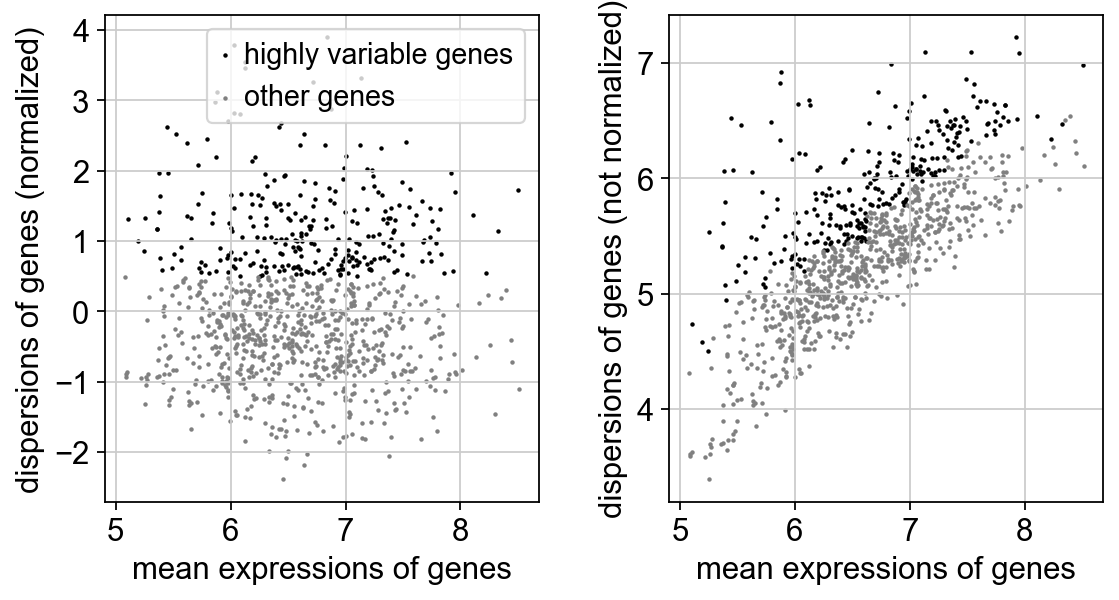

In [12]:
# normalize to 10K counts per cell
#sc.pp.normalize_total(adata, target_sum=1e6)

# log data
sc.pp.log1p(adata)

# get high variance genes
sc.pp.highly_variable_genes(adata, min_mean=0, max_mean=15, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(adata)

# now store the raw version of the data for our use later
#adata.raw = adata


In [13]:
# now process the counts further for doing DE 
# analysis and the cell clustering
adata = adata[:, adata.var.highly_variable]

# scale the genes
sc.pp.scale(adata, max_value=20)

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## PCA

In [14]:
sc.tl.pca(adata, n_comps=10)
sc.pp.neighbors(adata)
sc.tl.tsne(adata)


computing PCA
    on highly variable genes
    with n_comps=10
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:15)


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


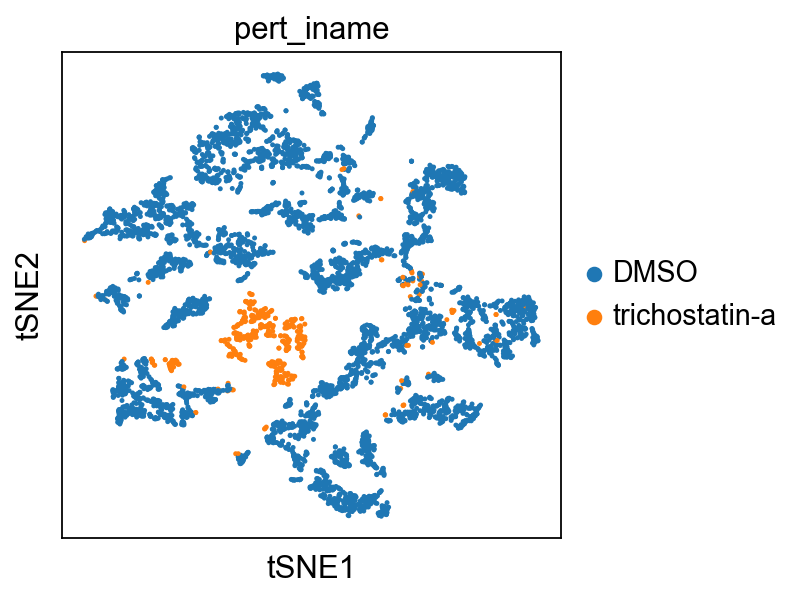

In [15]:
sc.pl.tsne(adata, color="pert_iname")

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


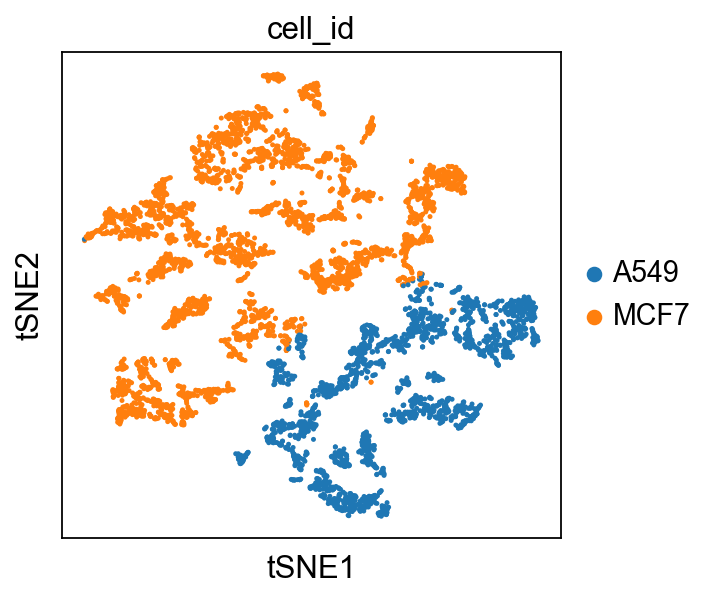

In [16]:
sc.pl.tsne(adata, color="cell_id")

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


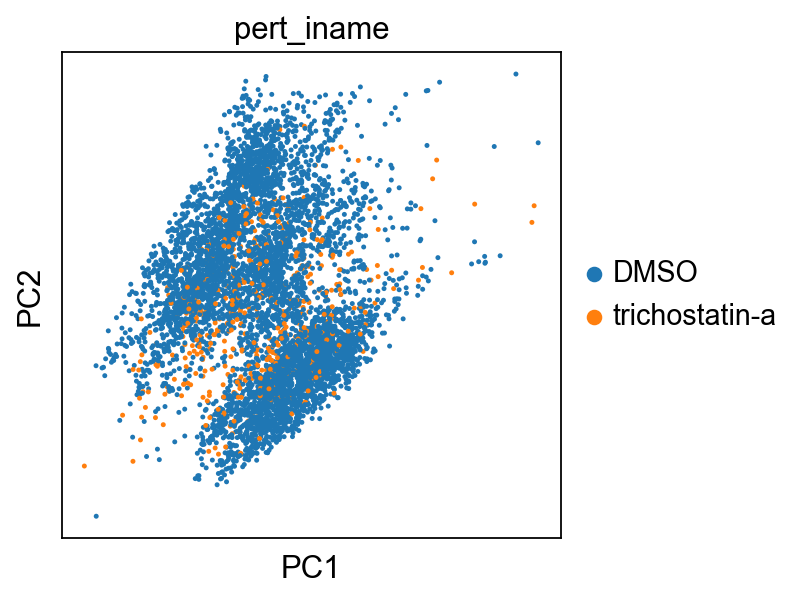

In [17]:
sc.pl.pca(adata, color="pert_iname")

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


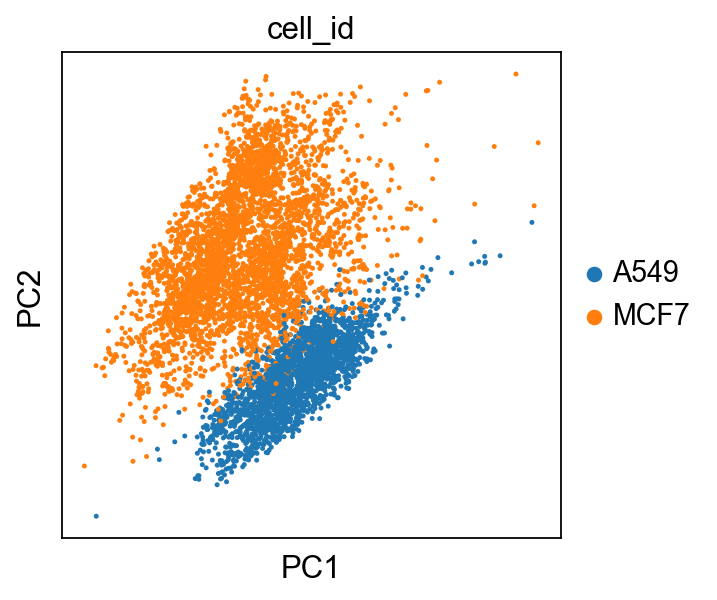

In [18]:
sc.pl.pca(adata, color="cell_id")

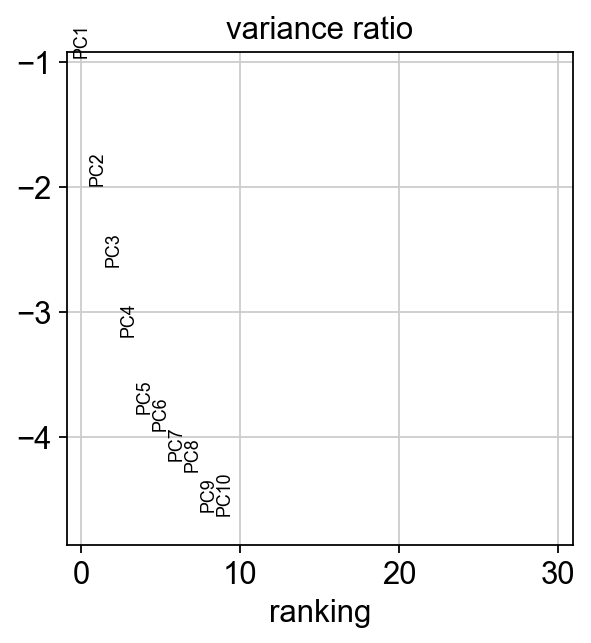

In [19]:
sc.pl.pca_variance_ratio(adata, log=True)



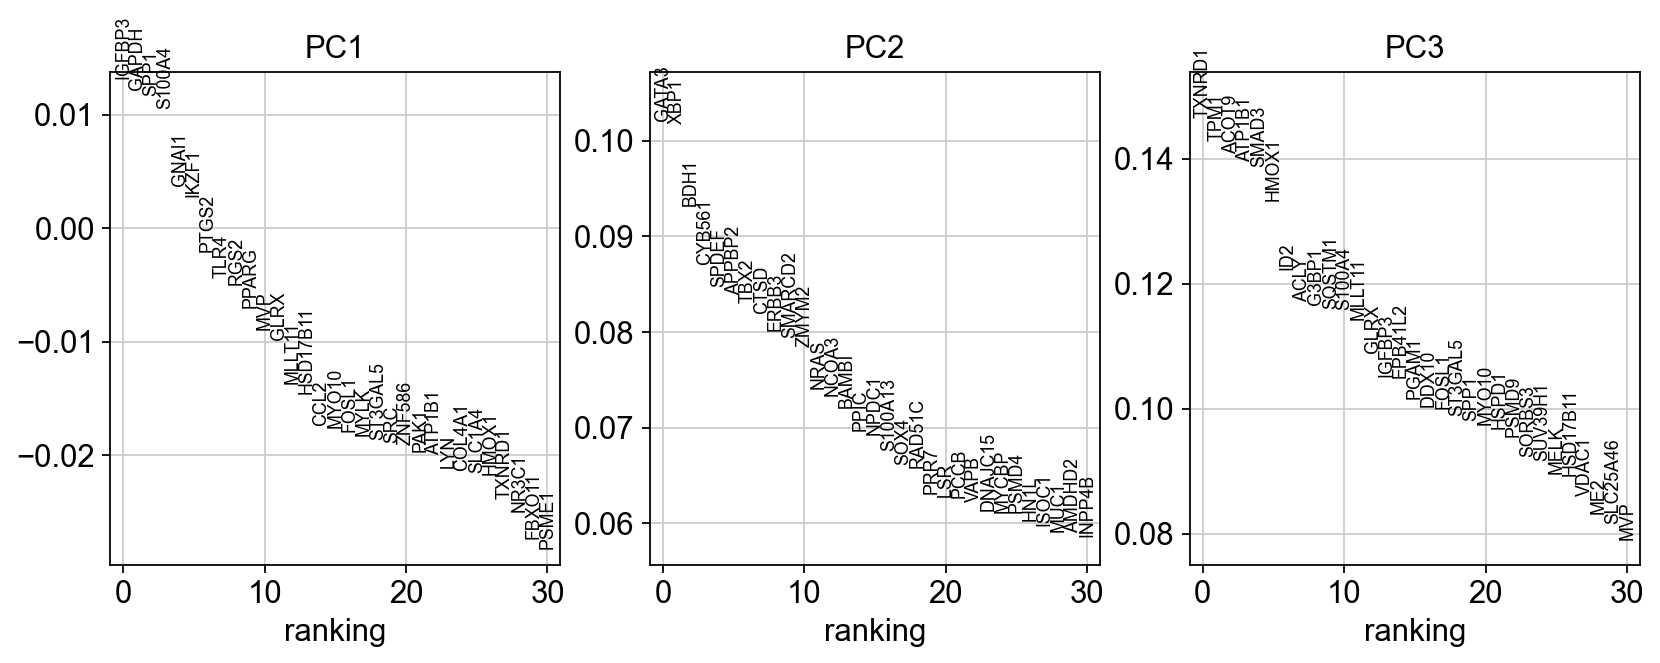

In [20]:
sc.pl.pca_loadings(adata, include_lowest=False)
